In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

from scipy.stats import norm

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from IPython.display import display, HTML

from collections import defaultdict

from src.plot_utils import plot_sample, plot_history
from src.cfd import CFD
from src.cfd_utils import TIME_STEP, plot_diff_hist_stats, _get_gauss_stats

In [2]:
dataset = np.load(PWD + f'/data/dataset.npz', allow_pickle=True)

In [3]:
all_channels_data = dataset['dataset'].flat[0]
all_channels_data.keys()

dict_keys([8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [4]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

FILTERS_MULT_SEP = 4

# Utils

In [5]:
def plot_samples(X, y, y_pred, indices=[10, 11, 12, 13, 500, 1000, 2000, 3000]):
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        plot_sample(X[idx])
        plt.axvline(y[idx], c='red')
        plt.axvline(y_pred[idx], c='orange')
        
        diff = abs(y[idx] - y_pred[idx])
        plt.title(f'Diff: {diff:0.4f} ({diff * TIME_STEP:0.4f}) ns')
        
def plot_difference_hist(y_true, y_pred, channel, method, hist_range=(-2, 2), n_bins=100, return_gauss_stats=True):
    mu, std = plot_diff_hist_stats(y_true, y_pred, show=False, n_bins=n_bins, hist_range=hist_range, hist_label=f'', plot_gauss=True, return_gauss_stats=return_gauss_stats)

    plt.title(f'{method}. channel={channel}, mean={mu:0.3f}, std={std:0.3f}')
    return std
    
def train_model(model, X_train, y_train, X_test, y_test, lr=0.001, name='model', train=True, 
                n_epochs=1000, verbose=1, batch_size=2048, lr_patience=None, es_patience=None, 
                loss_weights=None):
    model.compile(loss='mse', optimizer=optimizers.Adam(lr), loss_weights=loss_weights)

    model_callbacks = []
    model_callbacks.append(callbacks.ModelCheckpoint(filepath=f'model_weights/nn_channels_experiments/{name}/weights', save_best_only=True, save_weights_only=True))
    if es_patience is not None:
        model_callbacks.append(callbacks.EarlyStopping(patience=es_patience))
    if lr_patience is not None:
        model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=lr_patience))
    
    if train:
        history = model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=model_callbacks).history
        pd.DataFrame(history).to_csv(f'model_weights/nn_channels_experiments/{name}/loss_log.csv')

    model.load_weights(f'model_weights/nn_channels_experiments/{name}/weights')
    history = pd.read_csv(f'model_weights/nn_channels_experiments/{name}/loss_log.csv')
    
    return history

def load_model(model, lr=0.001, name='model', loss_weights=None):
    model.compile(loss='mse', optimizer=optimizers.Adam(lr), loss_weights=loss_weights)
    model.load_weights(f'model_weights/nn_channels_experiments/{name}/weights')

In [6]:
def augmentation_random_cut(X, y, n_edge_cut=8, seed=None, apply=True):
    if not apply:
        return X[:, n_edge_cut:-n_edge_cut], y - n_edge_cut
    random_state = np.random.RandomState(seed)
    n_to_cut = n_edge_cut * 2
    
    start = random_state.randint(low=0, high=n_to_cut, size=X.shape[0])
    end = X.shape[1] - n_to_cut + start
    
    X_new = np.empty(shape=(X.shape[0], X.shape[1] - n_to_cut))
    for i in range(X.shape[0]):
        X_new[i] = X[i, start[i]:end[i]]
        
    y_new = y - start
    return X_new, y_new

In [7]:
def pred_and_retrieve_y(model, X):
    Y_heatmap = model.predict(X, batch_size=8192)
    y_pred = np.empty(len(X))
    for i, y in enumerate(Y_heatmap):
        try:
            y_pred[i] = _get_gauss_stats(y)
        except:
            # print(f'Error calculating {i}')
            y_pred[i] = np.average(np.arange(len(y)), weights=y)
    return y_pred

def compare_model_with_cfd(model, cfd, X, y_true, channel=None, figsize=(12, 4), show=True, y_cfd=None, return_gauss_stats=True, log=True):
    if y_cfd is None:
        y_cfd = np.array([cfd.predict(x) for x in X])
        n_none = list(y_cfd).count(None)
        if n_none > 0:
            print(f'--------------------> CFD returned {n_none} Nones out of {len(y_cfd)} examples')
    y_cfd = y_cfd.astype(np.float64)
    y_model = pred_and_retrieve_y(model, X)
    
    mask = y_cfd != None
    y_true = y_true[mask]
    y_cfd = y_cfd[mask]
    y_model = y_model[mask]
    
    if log and channel is not None:
        display(HTML(f'<h4>Channel {channel}</h4>'))
    
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    std_cfd = plot_difference_hist(y_true, y_cfd, channel, 'CFD', hist_range=(-6, 6), n_bins=300, return_gauss_stats=return_gauss_stats)
    plt.subplot(1, 2, 2)
    std_model = plot_difference_hist(y_true, y_model, channel, 'NN', hist_range=(-6, 6), n_bins=300, return_gauss_stats=return_gauss_stats)
    
    improvement = (std_cfd - std_model) / std_cfd
    
    if log:
        print(f"CFD: {std_cfd:0.3f}, NN: {std_model:0.3f} ({std_cfd * TIME_STEP:0.3f} ns vs {std_model * TIME_STEP:0.3f} ns)")
        print(f'Improvement: {improvement * 100:0.2f} %')
    if show:
        plt.show()
    else:
        plt.close()
    return improvement
    
cfd = CFD(n_baseline=10, fraction=0.25)

In [8]:
def bold(phrase):
    return '\033[1m' + phrase + '\033[0;0m'

# Models

In [9]:
def gaussian_kernel(mu, sigma=0.8, n=48):
    x = np.arange(0, n)
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

_get_gauss_stats(gaussian_kernel(np.array(1.6)))

1.6

In [10]:
def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    # skip = residual_block(x, n_filters, strides=1)
    x = layers.MaxPooling1D()(skip)
    return skip, x
    
def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    # x = residual_block(x, n_filters, strides=1)
    return x
    
    
###################################

def create_model(filters_mult=1):
    inputs = layers.Input(48)
    x = layers.Reshape((-1, 1))(inputs)

    skip1, x = conv_block(x, 8 * filters_mult)
    skip2, x = conv_block(x, 16 * filters_mult)
    skip3, x = conv_block(x, 32 * filters_mult)
    x, _ = conv_block(x, 64 * filters_mult)

    x = deconv_block(x, skip3, 32 * filters_mult)
    x = deconv_block(x, skip2, 16 * filters_mult)
    x = deconv_block(x, skip1, 8 * filters_mult)

    x = layers.Conv1D(1, 1, activation='linear')(x)

    outputs = layers.Flatten()(x)

    model = tf.keras.Model(inputs, outputs)
    return model

## Trained separately, tested on the same channels

In [11]:
improvements = {}
for channel, (X, y) in list(all_channels_data.items()):
    X_aug, y_aug = augmentation_random_cut(X, y, 8, seed=42, apply=True)
    X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])
    
    model = create_model(filters_mult=FILTERS_MULT_SEP)
    history = train_model(model, X_train, Y_heatmap_train, X_test, Y_heatmap_test, lr=0.001, name=f'model_separate_{channel}', 
                          train=False, n_epochs=200, verbose=0, loss_weights=100, lr_patience=20, es_patience=40)
    
    # plot_history(history, f"Channel {channel}, {len(X)} events", ymax=1, figsize=(10, 4))
    improvement = compare_model_with_cfd(model, cfd, X_test, y_test, channel, show=False)
    improvements[channel] = improvement

1/1 [==============================] - 1s 1s/step


CFD: 0.453, NN: 0.361 (0.071 ns vs 0.056 ns)
Improvement: 20.39 %
1/1 [==============================] - 0s 177ms/step


CFD: 0.458, NN: 0.399 (0.072 ns vs 0.062 ns)
Improvement: 12.97 %
1/1 [==============================] - 0s 204ms/step


CFD: 0.407, NN: 0.362 (0.064 ns vs 0.056 ns)
Improvement: 11.21 %
1/1 [==============================] - 0s 187ms/step


CFD: 0.423, NN: 0.358 (0.066 ns vs 0.056 ns)
Improvement: 15.24 %
1/1 [==============================] - 0s 251ms/step


CFD: 0.779, NN: 0.639 (0.122 ns vs 0.100 ns)
Improvement: 18.01 %
1/1 [==============================] - 0s 456ms/step


CFD: 0.751, NN: 0.604 (0.117 ns vs 0.094 ns)
Improvement: 19.59 %
1/1 [==============================] - 0s 230ms/step


CFD: 0.442, NN: 0.338 (0.069 ns vs 0.053 ns)
Improvement: 23.52 %
1/1 [==============================] - 0s 186ms/step


CFD: 0.459, NN: 0.373 (0.072 ns vs 0.058 ns)
Improvement: 18.71 %
1/1 [==============================] - 0s 350ms/step


CFD: 0.441, NN: 0.385 (0.069 ns vs 0.060 ns)
Improvement: 12.68 %
1/1 [==============================] - 0s 252ms/step


CFD: 0.560, NN: 0.481 (0.088 ns vs 0.075 ns)
Improvement: 14.25 %
1/1 [==============================] - 0s 172ms/step


CFD: 0.430, NN: 0.379 (0.067 ns vs 0.059 ns)
Improvement: 11.97 %
1/1 [==============================] - 0s 319ms/step


CFD: 0.427, NN: 0.390 (0.067 ns vs 0.061 ns)
Improvement: 8.75 %
1/1 [==============================] - 0s 224ms/step


CFD: 0.410, NN: 0.365 (0.064 ns vs 0.057 ns)
Improvement: 11.04 %
1/1 [==============================] - 0s 237ms/step


CFD: 0.409, NN: 0.361 (0.064 ns vs 0.056 ns)
Improvement: 11.70 %
2/2 [==============================] - 1s 75ms/step


CFD: 0.598, NN: 0.512 (0.093 ns vs 0.080 ns)
Improvement: 14.34 %
1/1 [==============================] - 0s 470ms/step


CFD: 0.683, NN: 0.620 (0.107 ns vs 0.097 ns)
Improvement: 9.15 %
1/1 [==============================] - 0s 285ms/step


CFD: 0.768, NN: 0.662 (0.120 ns vs 0.103 ns)
Improvement: 13.77 %
2/2 [==============================] - 0s 172ms/step


CFD: 0.709, NN: 0.570 (0.111 ns vs 0.089 ns)
Improvement: 19.56 %
1/1 [==============================] - 0s 450ms/step


CFD: 0.487, NN: 0.388 (0.076 ns vs 0.061 ns)
Improvement: 20.37 %
1/1 [==============================] - 0s 190ms/step


CFD: 0.444, NN: 0.388 (0.069 ns vs 0.061 ns)
Improvement: 12.73 %
1/1 [==============================] - 0s 410ms/step


CFD: 0.468, NN: 0.391 (0.073 ns vs 0.061 ns)
Improvement: 16.55 %
1/1 [==============================] - 0s 173ms/step


CFD: 0.509, NN: 0.411 (0.079 ns vs 0.064 ns)
Improvement: 19.21 %


In [12]:
improvement_data = {ch: f'{value * 100:0.2f} %' for ch, value in improvements.items()}

df = pd.DataFrame(improvement_data.values(), index=improvement_data.keys(), columns=['improv (%)'])
df.index.name = 'channel'
df

,improv (%)
channel,
8,20.39 %
9,12.97 %
10,11.21 %
11,15.24 %
13,18.01 %
14,19.59 %
16,23.52 %
17,18.71 %
18,12.68 %


## Trained separately, tested separately

In [13]:
results = defaultdict(dict)
for model_channel in list(all_channels_data.keys()):
    print(f'Processing channel {model_channel}...')
    model = create_model(filters_mult=FILTERS_MULT_SEP)
    load_model(model, lr=0.001, name=f'model_separate_{model_channel}', loss_weights=100)
    
    for channel, (X, y) in list(all_channels_data.items()):
        X_aug, y_aug = augmentation_random_cut(X, y, 8, seed=42, apply=True)
        _, X_test, _, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])
        
        improvement = compare_model_with_cfd(model, cfd, X_test, y_test, channel, show=False, log=False)
        results[model_channel][channel] = improvement

Processing channel 8...
1/1 [==============================] - 0s 12ms/step
Processing channel 9...
1/1 [==============================] - 0s 12ms/step
Processing channel 10...
1/1 [==============================] - 0s 14ms/step
Processing channel 11...
1/1 [==============================] - 0s 12ms/step
Processing channel 13...
1/1 [==============================] - 0s 11ms/step
Processing channel 14...
1/1 [==============================] - 0s 13ms/step
Processing channel 16...
1/1 [==============================] - 0s 11ms/step
Processing channel 17...
1/1 [==============================] - 0s 15ms/step
Processing channel 18...
1/1 [==============================] - 0s 14ms/step
Processing channel 19...
1/1 [==============================] - 0s 12ms/step
Processing channel 20...
1/1 [==============================] - 0s 15ms/step
Processing channel 21...
1/1 [==============================] - 0s 13ms/step
Processing channel 22...
1/1 [==============================] - 0s 14ms/step
P

In [14]:
# Check that the order is the same
assert list(results.keys()) == sorted(results.keys())
for x in results.values():
    assert list(x.keys()) == sorted(x.keys())

row_names = [str(key) for key in results.keys()]
col_names = [str(key) for key in list(results.values())[0].keys()]

In [27]:
improv_data = np.array([list(f'{x * 100:0.2f} %' for x in r.values()) for r in results.values()])

df = pd.DataFrame(improv_data, index=row_names, columns=col_names)
df.index.name = 'trained on \ tested on'
with pd.option_context('display.max_columns', None):
    display(df)

,8,9,10,11,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
trained on \ tested on,,,,,,,,,,,,,,,,,,,,,,
8,20.39 %,8.45 %,9.34 %,10.01 %,-9.50 %,-7.80 %,5.51 %,8.44 %,3.16 %,2.22 %,7.02 %,-4.47 %,6.84 %,5.19 %,-7.27 %,-4.03 %,-14.58 %,-10.95 %,3.70 %,2.18 %,-10.62 %,-2.64 %
9,13.36 %,12.97 %,9.39 %,10.11 %,4.90 %,2.95 %,3.37 %,9.34 %,1.33 %,3.24 %,2.03 %,1.86 %,5.17 %,2.98 %,-6.50 %,0.64 %,-4.04 %,-14.14 %,5.22 %,0.99 %,-5.74 %,-6.94 %
10,7.89 %,4.53 %,11.21 %,10.96 %,8.62 %,8.24 %,3.08 %,12.12 %,3.96 %,-3.45 %,-0.72 %,2.54 %,5.91 %,5.23 %,-0.19 %,3.47 %,4.86 %,-2.73 %,8.15 %,1.57 %,-1.84 %,-6.72 %
11,3.45 %,-7.94 %,9.06 %,15.24 %,-22.44 %,-20.87 %,14.99 %,12.71 %,3.63 %,-24.67 %,-1.94 %,-7.64 %,10.08 %,10.66 %,-4.83 %,-10.12 %,-31.32 %,1.74 %,11.07 %,4.87 %,-5.96 %,-13.19 %
13,2.94 %,-5.92 %,-7.56 %,-9.68 %,18.01 %,15.79 %,-21.18 %,-1.69 %,-14.63 %,-3.42 %,-8.14 %,-12.97 %,-16.77 %,-17.01 %,4.91 %,6.41 %,9.36 %,6.68 %,-5.47 %,-19.07 %,-22.64 %,-13.89 %
14,-3.36 %,-3.60 %,-8.72 %,-14.46 %,16.14 %,19.59 %,-17.60 %,3.83 %,-7.18 %,4.10 %,-8.06 %,-13.61 %,-14.73 %,-18.53 %,3.58 %,7.14 %,13.17 %,11.82 %,1.72 %,-12.10 %,-5.63 %,-2.94 %
16,-4.38 %,-14.99 %,0.23 %,12.14 %,-12.15 %,-9.71 %,23.52 %,15.35 %,7.50 %,-26.30 %,-0.55 %,-13.77 %,10.06 %,12.90 %,-26.45 %,-24.49 %,-4.95 %,-2.42 %,15.02 %,10.42 %,4.79 %,2.87 %
17,-3.32 %,-3.27 %,8.11 %,8.36 %,8.12 %,11.17 %,15.17 %,18.71 %,7.24 %,-1.39 %,-9.00 %,-4.82 %,8.53 %,8.31 %,6.32 %,2.77 %,6.25 %,10.80 %,18.10 %,8.04 %,7.92 %,-11.53 %
18,1.71 %,-0.33 %,1.46 %,5.57 %,-22.56 %,-22.12 %,11.97 %,11.88 %,12.68 %,-9.68 %,-0.80 %,-4.72 %,4.59 %,1.27 %,-26.50 %,-28.47 %,-15.53 %,-15.61 %,7.18 %,6.22 %,8.49 %,-1.24 %


## Trained on all the channels, tested on separate channels

In [16]:
X_all_train, X_all_test, y_all_train, y_all_test = [], [], [], []

for X, y in list(all_channels_data.values()):
    X_aug, y_aug = augmentation_random_cut(X, y, 8, seed=42, apply=True)
    X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    X_all_train.append(X_train)
    X_all_test.append(X_test)
    y_all_train.append(y_train)
    y_all_test.append(y_test)
    
X_all_train = np.concatenate(X_all_train)
X_all_test = np.concatenate(X_all_test)
y_all_train = np.concatenate(y_all_train)
y_all_test = np.concatenate(y_all_test)

Y_all_heatmap_train = np.array([gaussian_kernel(y) for y in y_all_train])
Y_all_heatmap_test = np.array([gaussian_kernel(y) for y in y_all_test])

X_all_train.shape, X_all_test.shape, y_all_train.shape, y_all_test.shape

((416976, 48), (104257, 48), (416976,), (104257,))

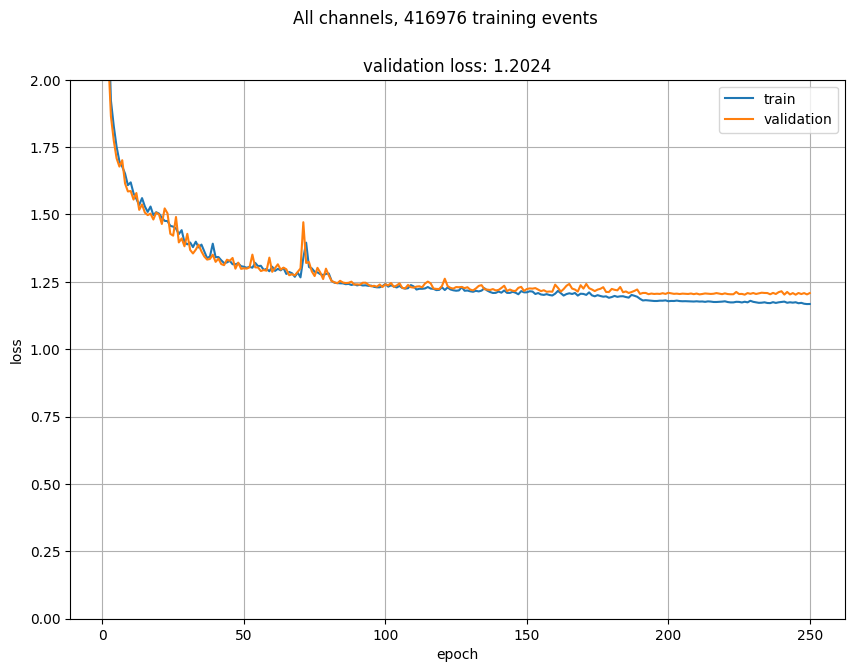

In [17]:
model = create_model(filters_mult=4)

history = train_model(model, X_all_train, Y_all_heatmap_train, X_all_test, Y_all_heatmap_test, lr=0.01, name=f'model_all_channels', 
                      batch_size=16384, train=False, n_epochs=250, verbose=1, loss_weights=100, lr_patience=10, es_patience=25)

plot_history(history, f"All channels, {len(X_all_train)} training events", ymax=2, figsize=(10, 7))

In [18]:
improvements = {}
for channel, (X, y) in list(all_channels_data.items()):
    X_aug, y_aug = augmentation_random_cut(X, y, 8, seed=42, apply=True)
    _, X_test, _, y_test = train_test_split(X_aug, y_aug, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

    improvement = compare_model_with_cfd(model, cfd, X_test, y_test, channel, show=False)
    improvements[channel] = improvement

1/1 [==============================] - 0s 130ms/step


CFD: 0.453, NN: 0.773 (0.071 ns vs 0.121 ns)
Improvement: -70.67 %
1/1 [==============================] - 0s 14ms/step


CFD: 0.458, NN: 0.713 (0.072 ns vs 0.111 ns)
Improvement: -55.62 %
1/1 [==============================] - 0s 17ms/step


CFD: 0.407, NN: 0.581 (0.064 ns vs 0.091 ns)
Improvement: -42.73 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.423, NN: 0.659 (0.066 ns vs 0.103 ns)
Improvement: -55.84 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.779, NN: 1.129 (0.122 ns vs 0.176 ns)
Improvement: -44.84 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.751, NN: 1.164 (0.117 ns vs 0.182 ns)
Improvement: -55.01 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.442, NN: 0.960 (0.069 ns vs 0.150 ns)
Improvement: -117.30 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.459, NN: 0.808 (0.072 ns vs 0.126 ns)
Improvement: -76.19 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.441, NN: 0.978 (0.069 ns vs 0.153 ns)
Improvement: -121.52 %
1/1 [==============================] - 0s 14ms/step


CFD: 0.560, NN: 0.924 (0.088 ns vs 0.144 ns)
Improvement: -64.93 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.430, NN: 0.781 (0.067 ns vs 0.122 ns)
Improvement: -81.57 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.427, NN: 0.803 (0.067 ns vs 0.125 ns)
Improvement: -87.95 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.410, NN: 0.744 (0.064 ns vs 0.116 ns)
Improvement: -81.40 %
1/1 [==============================] - 0s 14ms/step


CFD: 0.409, NN: 0.792 (0.064 ns vs 0.124 ns)
Improvement: -93.73 %
2/2 [==============================] - 0s 37ms/step


CFD: 0.598, NN: 0.735 (0.093 ns vs 0.115 ns)
Improvement: -22.87 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.683, NN: 0.947 (0.107 ns vs 0.148 ns)
Improvement: -38.70 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.768, NN: 1.031 (0.120 ns vs 0.161 ns)
Improvement: -34.23 %
2/2 [==============================] - 0s 45ms/step


CFD: 0.709, NN: 0.678 (0.111 ns vs 0.106 ns)
Improvement: 4.33 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.487, NN: 0.845 (0.076 ns vs 0.132 ns)
Improvement: -73.48 %
1/1 [==============================] - 0s 13ms/step


CFD: 0.444, NN: 1.018 (0.069 ns vs 0.159 ns)
Improvement: -129.14 %
1/1 [==============================] - 0s 15ms/step


CFD: 0.468, NN: 0.858 (0.073 ns vs 0.134 ns)
Improvement: -83.32 %
1/1 [==============================] - 0s 12ms/step


CFD: 0.509, NN: 0.806 (0.079 ns vs 0.126 ns)
Improvement: -58.58 %


In [19]:
improvement_data = {ch: f'{value * 100:0.2f} %' for ch, value in improvements.items()}

df = pd.DataFrame(improvement_data.values(), index=improvement_data.keys(), columns=['improv (%)'])
df.index.name = 'channel'
df

,improv (%)
channel,
8,-70.67 %
9,-55.62 %
10,-42.73 %
11,-55.84 %
13,-44.84 %
14,-55.01 %
16,-117.30 %
17,-76.19 %
18,-121.52 %
